# LightGBM
### Parameters:
* **abilities**:
    * **cha**
    * **con**
    * **dex**
    * **int**
    * **str**
    * **wis**
* **attributes**
    * **hp**
    * **ac**
    * **perception**
* **saves**
    * **fortitude**
    * **reflex**
    * **will**
* **resources**
    * **focus**

### Prediction: *level*

## Loading data

In [1]:
import numpy as np
import pandas as pd
import sys

import os
import pathlib

sys.path.append("../../..")
from training.creating_dataset import load_and_preprocess_data

current_path = os.getcwd()
DATASETS_DIR = pathlib.Path(current_path).parent.parent.parent / "pathfinder_2e_data"
DATASET_FILES = [
    "pathfinder-bestiary.db",
    "pathfinder-bestiary-2.db",
    "pathfinder-bestiary-3.db",
]
DATASET_PATHS = [f"{DATASETS_DIR}/{file}" for file in DATASET_FILES]
features = [
    "cha",
    "con",
    "dex",
    "int",
    "str",
    "wis",
    "ac",
    "hp",
    "perception",
    "fortitude",
    "reflex",
    "will",
    "focus",
]

df = load_and_preprocess_data(
    DATASET_PATHS,
    characteristics=features,
)

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1206 entries, 0 to 1205
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   con         1206 non-null   int64 
 1   int         1206 non-null   int64 
 2   str         1206 non-null   int64 
 3   will        1206 non-null   int64 
 4   book        1206 non-null   object
 5   wis         1206 non-null   int64 
 6   hp          1206 non-null   int64 
 7   perception  1206 non-null   int64 
 8   cha         1206 non-null   int64 
 9   level       1206 non-null   int64 
 10  reflex      1206 non-null   int64 
 11  ac          1206 non-null   int64 
 12  dex         1206 non-null   int64 
 13  fortitude   1206 non-null   int64 
 14  focus       1206 non-null   int32 
dtypes: int32(1), int64(13), object(1)
memory usage: 146.0+ KB


In [3]:
df.head()

,con,int,str,will,book,wis,hp,perception,cha,level,reflex,ac,dex,fortitude,focus
0,5,1,7,17,Pathfinder Bestiary,2,215,20,1,10,19,29,2,22,1
1,5,-4,9,16,Pathfinder Bestiary,2,220,16,1,10,14,28,0,21,0
2,6,-4,7,15,Pathfinder Bestiary,3,175,17,-2,8,17,25,3,20,0
3,5,6,7,32,Pathfinder Bestiary,5,315,30,6,17,29,41,4,30,1
4,1,-1,-5,4,Pathfinder Bestiary,1,20,6,1,1,10,16,3,6,1


###### Level

In [4]:
y = df["level"]
y

0       10
1       10
2        8
3       17
4        1
        ..
1201    20
1202    -1
1203    12
1204     6
1205     6
Name: level, Length: 1206, dtype: int64

In [5]:
from collections import defaultdict


lvl_stat = defaultdict(lambda: 0)

for lvl in y:
    lvl_stat[lvl] += 1

In [6]:
level_count = pd.DataFrame(
    data={
        "lvl": [key for key in sorted(lvl_stat.keys())],
        "count": [lvl_stat.get(key) for key in sorted(lvl_stat.keys())],
    }
)
level_count

,lvl,count
0,-1,34
1,0,27
2,1,127
3,2,121
4,3,95
5,4,82
6,5,76
7,6,72
8,7,77
9,8,68


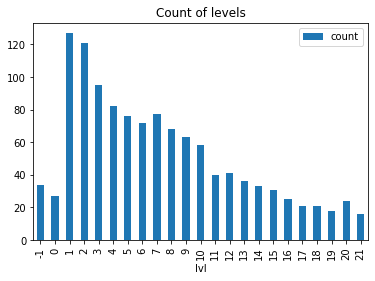

In [7]:
import matplotlib.pyplot as plt


level_count.plot.bar(x="lvl", y="count", title="Count of levels")
plt.show()

## Train test split

### Chronological split

In [8]:
from training.splitting_dataset import split_dataframe


os.chdir("../../../training")
X_train, X_test, y_train, y_test = split_dataframe(df, test_size=0.31)
os.chdir("../notebooks/models/lightgbm")

In [9]:
X_train = X_train.drop(columns=["book"])
X_test = X_test.drop(columns=["book"])

### Random split

In [10]:
(
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
) = split_dataframe(df, chronological_split=False)

In [11]:
X_train_random_split = X_train_random_split.drop(columns=["book"])
X_test_random_split = X_test_random_split.drop(columns=["book"])

## LightGBM

## Chronological split

In [12]:
import lightgbm as lgb

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 379
[LightGBM] [Info] Number of data points in the train set: 841, number of used features: 13
[LightGBM] [Info] Start training from score 6.966706
Training until validation scores don't improve for 5 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

In [13]:
y_pred_train = gbm.predict(X_train, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test, num_iteration=gbm.best_iteration)

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test, y_pred_test, squared=False)
mae = mean_absolute_error(y_test, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.51
MAE: 0.36


In [15]:
results = pd.DataFrame(
    data={
        "Split type": [],
        "Tuning type": [],
        "Set of features": [],
        "RMSE": [],
        "MAE": [],
    }
)

results.loc[0] = ["chronological", "default", "expanded", rmse, mae]

In [16]:
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
print(f"RMSE train: {rmse_train:.2f}")
print(f"RMSE test: {rmse_test:.2f}")

RMSE train: 0.21
RMSE test: 0.51


###### MAE by level

In [17]:
from training.results import plot_mae_by_level

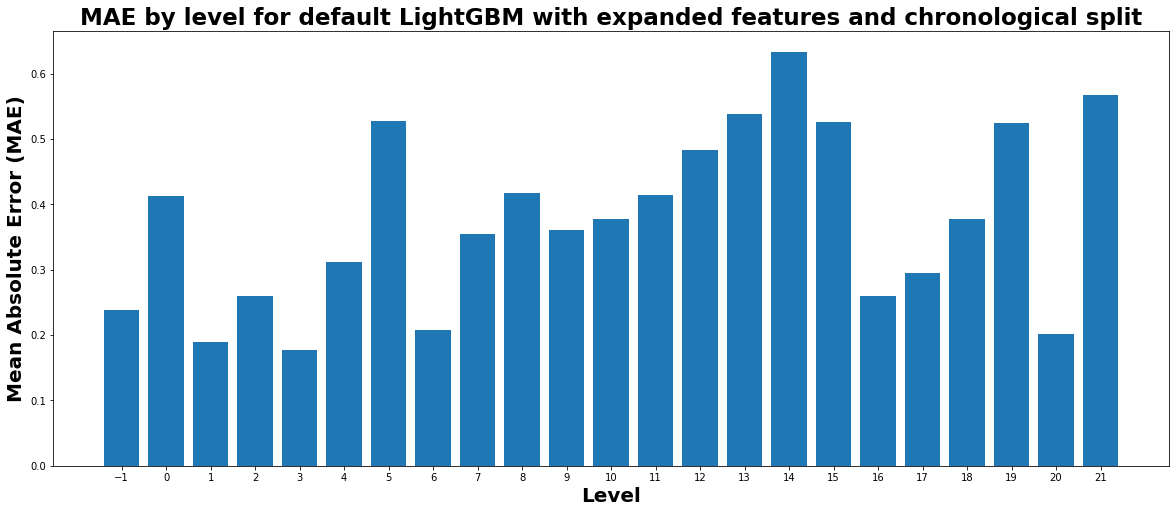

In [18]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for default LightGBM with expanded features and chronological split",
)

In [19]:
from training.results import evaluate_round_predictions, plot_confusion_matrix


evaluate_round_predictions([0.5, 0.33, 0.45], y_test, y_pred_test)

Default:
RMSE: 0.51

Round type: 0.5
RMSE: 0.55

Round type: 0.33
RMSE: 0.54

Round type: 0.45
RMSE: 0.54



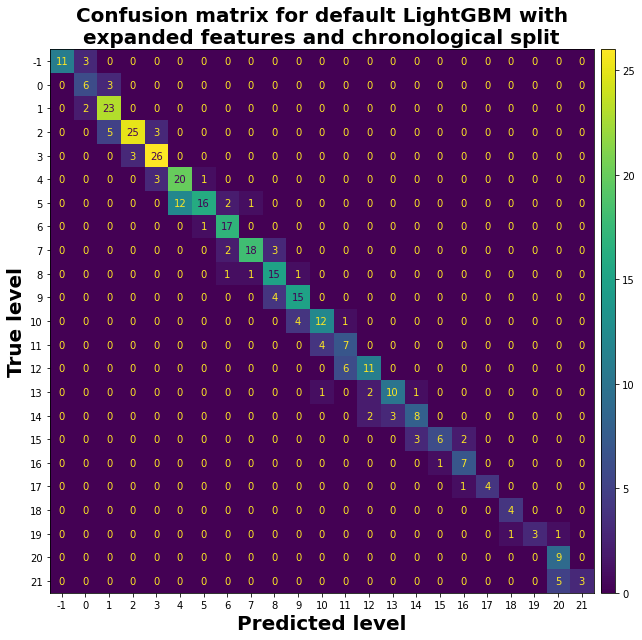

In [20]:
plot_confusion_matrix(
    y_pred_test,
    y_test,
    title="Confusion matrix for default LightGBM with\nexpanded features and chronological split",
)

#### Tuning

In [21]:
from training.results import assess_regression_model

In [22]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train, y_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-09 20:46:47,315] A new study created in memory with name: no-name-0d68f207-1538-40b5-bd18-5f3fce5140b8
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.177581 + 0.032274
[200]	cv_agg's l2: 0.174627 + 0.0318199
[300]	cv_agg's l2: 0.174453 + 0.0325213
Early stopping, best iteration is:
[217]	cv_agg's l2: 0.17408 + 0.031923


feature_fraction, val_score: 0.174080:  14%|######4                                      | 1/7 [00:04<00:28,  4.83s/it]

[100]	cv_agg's l2: 0.159903 + 0.0241276
[200]	cv_agg's l2: 0.158282 + 0.0224231


feature_fraction, val_score: 0.157978:  29%|############8                                | 2/7 [00:08<00:21,  4.39s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.157978 + 0.0225326
[100]	cv_agg's l2: 0.177148 + 0.0380835
[200]	cv_agg's l2: 0.173294 + 0.0371064


feature_fraction, val_score: 0.157978:  43%|###################2                         | 3/7 [00:14<00:19,  4.82s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.157978 + 0.0225326
[100]	cv_agg's l2: 0.177335 + 0.0332588
[200]	cv_agg's l2: 0.172948 + 0.0311771


feature_fraction, val_score: 0.157978:  57%|#########################7                   | 4/7 [00:17<00:12,  4.22s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.157978 + 0.0225326
[100]	cv_agg's l2: 0.188025 + 0.0387054
[200]	cv_agg's l2: 0.185965 + 0.0366299


feature_fraction, val_score: 0.157978:  71%|################################1            | 5/7 [00:21<00:08,  4.07s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.157978 + 0.0225326
[100]	cv_agg's l2: 0.176664 + 0.0312799
[200]	cv_agg's l2: 0.174798 + 0.0300581


feature_fraction, val_score: 0.157978:  86%|######################################5      | 6/7 [00:24<00:03,  3.83s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.157978 + 0.0225326
[100]	cv_agg's l2: 0.178022 + 0.0303758
[200]	cv_agg's l2: 0.173516 + 0.030121


feature_fraction, val_score: 0.157978: 100%|#############################################| 7/7 [00:28<00:00,  4.06s/it]


Early stopping, best iteration is:
[193]	cv_agg's l2: 0.157978 + 0.0225326


num_leaves, val_score: 0.157978:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.159903 + 0.0241276
[200]	cv_agg's l2: 0.158282 + 0.0224231


num_leaves, val_score: 0.157978:   5%|##5                                               | 1/20 [00:03<01:06,  3.49s/it]

Early stopping, best iteration is:
[193]	cv_agg's l2: 0.157978 + 0.0225326
[100]	cv_agg's l2: 0.159777 + 0.0244288
[200]	cv_agg's l2: 0.156702 + 0.022341
[300]	cv_agg's l2: 0.156912 + 0.0229566


num_leaves, val_score: 0.156273:  10%|#####                                             | 2/20 [00:08<01:15,  4.18s/it]

Early stopping, best iteration is:
[271]	cv_agg's l2: 0.156273 + 0.022415
[100]	cv_agg's l2: 0.159903 + 0.0241276
[200]	cv_agg's l2: 0.158282 + 0.0224231
[300]	cv_agg's l2: 0.15919 + 0.0224695


num_leaves, val_score: 0.156273:  15%|#######5                                          | 3/20 [00:12<01:10,  4.15s/it]

Early stopping, best iteration is:
[271]	cv_agg's l2: 0.156273 + 0.022415
[100]	cv_agg's l2: 0.159903 + 0.0241276
[200]	cv_agg's l2: 0.158282 + 0.0224231
[300]	cv_agg's l2: 0.15919 + 0.0224695


num_leaves, val_score: 0.156273:  20%|##########                                        | 4/20 [00:16<01:06,  4.19s/it]

Early stopping, best iteration is:
[271]	cv_agg's l2: 0.156273 + 0.022415
[100]	cv_agg's l2: 0.199973 + 0.0197539
[200]	cv_agg's l2: 0.179143 + 0.0172941
[300]	cv_agg's l2: 0.172255 + 0.0154554


num_leaves, val_score: 0.156273:  25%|############5                                     | 5/20 [00:17<00:46,  3.12s/it]

Early stopping, best iteration is:
[271]	cv_agg's l2: 0.156273 + 0.022415
[100]	cv_agg's l2: 0.159903 + 0.0241276
[200]	cv_agg's l2: 0.158282 + 0.0224231
[300]	cv_agg's l2: 0.15919 + 0.0224695


num_leaves, val_score: 0.156273:  30%|###############                                   | 6/20 [00:22<00:49,  3.56s/it]

Early stopping, best iteration is:
[271]	cv_agg's l2: 0.156273 + 0.022415
[100]	cv_agg's l2: 0.193074 + 0.0191257
[200]	cv_agg's l2: 0.174551 + 0.0166917
[300]	cv_agg's l2: 0.16867 + 0.0163985


num_leaves, val_score: 0.156273:  35%|#################5                                | 7/20 [00:23<00:36,  2.79s/it]

Early stopping, best iteration is:
[271]	cv_agg's l2: 0.156273 + 0.022415
[100]	cv_agg's l2: 0.159903 + 0.0241276
[200]	cv_agg's l2: 0.158282 + 0.0224231
[300]	cv_agg's l2: 0.15919 + 0.0224695


num_leaves, val_score: 0.156273:  40%|####################                              | 8/20 [00:27<00:38,  3.23s/it]

Early stopping, best iteration is:
[271]	cv_agg's l2: 0.156273 + 0.022415
[100]	cv_agg's l2: 0.159903 + 0.0241276
[200]	cv_agg's l2: 0.158282 + 0.0224231
[300]	cv_agg's l2: 0.15919 + 0.0224695


num_leaves, val_score: 0.156273:  45%|######################5                           | 9/20 [00:31<00:38,  3.53s/it]

Early stopping, best iteration is:
[271]	cv_agg's l2: 0.156273 + 0.022415
[100]	cv_agg's l2: 0.159903 + 0.0241276
[200]	cv_agg's l2: 0.158282 + 0.0224231
[300]	cv_agg's l2: 0.15919 + 0.0224695


num_leaves, val_score: 0.156273:  50%|########################5                        | 10/20 [00:36<00:37,  3.77s/it]

Early stopping, best iteration is:
[271]	cv_agg's l2: 0.156273 + 0.022415
[100]	cv_agg's l2: 0.159903 + 0.0241276
[200]	cv_agg's l2: 0.158282 + 0.0224231
[300]	cv_agg's l2: 0.15919 + 0.0224695


num_leaves, val_score: 0.156273:  55%|##########################9                      | 11/20 [00:40<00:35,  3.96s/it]

Early stopping, best iteration is:
[271]	cv_agg's l2: 0.156273 + 0.022415
[100]	cv_agg's l2: 0.159903 + 0.0241276
[200]	cv_agg's l2: 0.158282 + 0.0224231
[300]	cv_agg's l2: 0.15919 + 0.0224695


num_leaves, val_score: 0.156273:  60%|#############################4                   | 12/20 [00:44<00:32,  4.12s/it]

Early stopping, best iteration is:
[271]	cv_agg's l2: 0.156273 + 0.022415
[100]	cv_agg's l2: 0.159903 + 0.0241276
[200]	cv_agg's l2: 0.158282 + 0.0224231
[300]	cv_agg's l2: 0.15919 + 0.0224695


num_leaves, val_score: 0.156273:  65%|###############################8                 | 13/20 [00:49<00:30,  4.40s/it]

Early stopping, best iteration is:
[271]	cv_agg's l2: 0.156273 + 0.022415
[100]	cv_agg's l2: 0.159903 + 0.0241276
[200]	cv_agg's l2: 0.158282 + 0.0224231
[300]	cv_agg's l2: 0.15919 + 0.0224695


num_leaves, val_score: 0.156273:  70%|##################################3              | 14/20 [00:55<00:28,  4.70s/it]

Early stopping, best iteration is:
[271]	cv_agg's l2: 0.156273 + 0.022415
[100]	cv_agg's l2: 0.159903 + 0.0241276
[200]	cv_agg's l2: 0.158282 + 0.0224231
[300]	cv_agg's l2: 0.15919 + 0.0224695


num_leaves, val_score: 0.156273:  75%|####################################7            | 15/20 [00:59<00:23,  4.65s/it]

Early stopping, best iteration is:
[271]	cv_agg's l2: 0.156273 + 0.022415
[100]	cv_agg's l2: 0.159903 + 0.0241276
[200]	cv_agg's l2: 0.158282 + 0.0224231
[300]	cv_agg's l2: 0.15919 + 0.0224695


num_leaves, val_score: 0.156273:  80%|#######################################2         | 16/20 [01:04<00:18,  4.60s/it]

Early stopping, best iteration is:
[271]	cv_agg's l2: 0.156273 + 0.022415
[100]	cv_agg's l2: 0.159903 + 0.0241276
[200]	cv_agg's l2: 0.158282 + 0.0224231
[300]	cv_agg's l2: 0.15919 + 0.0224695


num_leaves, val_score: 0.156273:  85%|#########################################6       | 17/20 [01:08<00:13,  4.54s/it]

Early stopping, best iteration is:
[271]	cv_agg's l2: 0.156273 + 0.022415
[100]	cv_agg's l2: 0.159903 + 0.0241276
[200]	cv_agg's l2: 0.158282 + 0.0224231
[300]	cv_agg's l2: 0.15919 + 0.0224695


num_leaves, val_score: 0.156273:  90%|############################################1    | 18/20 [01:13<00:09,  4.54s/it]

Early stopping, best iteration is:
[271]	cv_agg's l2: 0.156273 + 0.022415
[100]	cv_agg's l2: 0.159903 + 0.0241276
[200]	cv_agg's l2: 0.158282 + 0.0224231
[300]	cv_agg's l2: 0.15919 + 0.0224695


num_leaves, val_score: 0.156273:  95%|##############################################5  | 19/20 [01:17<00:04,  4.52s/it]

Early stopping, best iteration is:
[271]	cv_agg's l2: 0.156273 + 0.022415
[100]	cv_agg's l2: 0.158422 + 0.0209401
[200]	cv_agg's l2: 0.156468 + 0.0206372


num_leaves, val_score: 0.155776: 100%|#################################################| 20/20 [01:20<00:00,  4.03s/it]


Early stopping, best iteration is:
[175]	cv_agg's l2: 0.155776 + 0.0211252


bagging, val_score: 0.155776:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.168832 + 0.0269172
[200]	cv_agg's l2: 0.165794 + 0.0250505


bagging, val_score: 0.155776:  10%|#####3                                               | 1/10 [00:03<00:27,  3.02s/it]

Early stopping, best iteration is:
[175]	cv_agg's l2: 0.155776 + 0.0211252
[100]	cv_agg's l2: 0.196929 + 0.024865
[200]	cv_agg's l2: 0.187594 + 0.0222197


bagging, val_score: 0.155776:  20%|##########6                                          | 2/10 [00:04<00:18,  2.37s/it]

Early stopping, best iteration is:
[175]	cv_agg's l2: 0.155776 + 0.0211252
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.155161 + 0.0200584


bagging, val_score: 0.154620:  30%|###############9                                     | 3/10 [00:08<00:19,  2.79s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.159361 + 0.0251636
[200]	cv_agg's l2: 0.156824 + 0.0223846


bagging, val_score: 0.154620:  40%|#####################2                               | 4/10 [00:11<00:18,  3.01s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.160398 + 0.025224
[200]	cv_agg's l2: 0.158049 + 0.0227327


bagging, val_score: 0.154620:  50%|##########################5                          | 5/10 [00:15<00:15,  3.16s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.158422 + 0.0209401
[200]	cv_agg's l2: 0.156468 + 0.0206372


bagging, val_score: 0.154620:  60%|###############################8                     | 6/10 [00:18<00:12,  3.22s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.159012 + 0.0233653
[200]	cv_agg's l2: 0.15724 + 0.021764


bagging, val_score: 0.154620:  70%|#####################################                | 7/10 [00:21<00:09,  3.25s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.167901 + 0.0290439
[200]	cv_agg's l2: 0.163199 + 0.0250212


bagging, val_score: 0.154620:  80%|##########################################4          | 8/10 [00:24<00:06,  3.17s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.169197 + 0.0304313
[200]	cv_agg's l2: 0.164831 + 0.0248923


bagging, val_score: 0.154620:  90%|###############################################7     | 9/10 [00:28<00:03,  3.23s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.184064 + 0.0318909
[200]	cv_agg's l2: 0.183929 + 0.0284596


bagging, val_score: 0.154620: 100%|####################################################| 10/10 [00:30<00:00,  3.06s/it]


Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823


feature_fraction_stage2, val_score: 0.154620:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.155161 + 0.0200584


feature_fraction_stage2, val_score: 0.154620:  33%|############6                         | 1/3 [00:03<00:06,  3.43s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.165739 + 0.0268619
[200]	cv_agg's l2: 0.162767 + 0.0241905


feature_fraction_stage2, val_score: 0.154620:  67%|#########################3            | 2/3 [00:06<00:03,  3.30s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.165739 + 0.0268619
[200]	cv_agg's l2: 0.162767 + 0.0241905


feature_fraction_stage2, val_score: 0.154620: 100%|######################################| 3/3 [00:09<00:00,  3.29s/it]


Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823


regularization_factors, val_score: 0.154620:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.157806 + 0.021526
[200]	cv_agg's l2: 0.157542 + 0.0178733


regularization_factors, val_score: 0.154620:   5%|#9                                    | 1/20 [00:03<01:05,  3.43s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.155161 + 0.0200584


regularization_factors, val_score: 0.154620:  10%|###8                                  | 2/20 [00:06<01:00,  3.34s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.155161 + 0.0200584


regularization_factors, val_score: 0.154620:  15%|#####7                                | 3/20 [00:10<00:57,  3.37s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.155161 + 0.0200584


regularization_factors, val_score: 0.154620:  20%|#######6                              | 4/20 [00:13<00:53,  3.35s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.155161 + 0.0200584


regularization_factors, val_score: 0.154620:  25%|#########5                            | 5/20 [00:16<00:50,  3.35s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.155161 + 0.0200584


regularization_factors, val_score: 0.154620:  30%|###########4                          | 6/20 [00:19<00:46,  3.30s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.155161 + 0.0200584


regularization_factors, val_score: 0.154620:  35%|#############3                        | 7/20 [00:23<00:42,  3.30s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.155161 + 0.0200584


regularization_factors, val_score: 0.154620:  40%|###############2                      | 8/20 [00:26<00:39,  3.27s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.155161 + 0.0200584


regularization_factors, val_score: 0.154620:  45%|#################1                    | 9/20 [00:29<00:36,  3.28s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.155161 + 0.0200584


regularization_factors, val_score: 0.154620:  50%|##################5                  | 10/20 [00:33<00:32,  3.28s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.155161 + 0.0200584


regularization_factors, val_score: 0.154620:  55%|####################3                | 11/20 [00:36<00:29,  3.30s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.155161 + 0.0200584


regularization_factors, val_score: 0.154620:  60%|######################2              | 12/20 [00:39<00:26,  3.27s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.15462 + 0.0200823
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.154895 + 0.0197888


regularization_factors, val_score: 0.154287:  65%|########################             | 13/20 [00:43<00:23,  3.30s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.154287 + 0.0197394
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.154895 + 0.0197889


regularization_factors, val_score: 0.154287:  70%|#########################9           | 14/20 [00:46<00:19,  3.33s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.154287 + 0.0197394
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.155267 + 0.0197187


regularization_factors, val_score: 0.154287:  75%|###########################7         | 15/20 [00:49<00:16,  3.32s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.154287 + 0.0197394
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.155267 + 0.0197187


regularization_factors, val_score: 0.154287:  80%|#############################6       | 16/20 [00:52<00:13,  3.28s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.154287 + 0.0197394
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.154895 + 0.0197889


regularization_factors, val_score: 0.154287:  85%|###############################4     | 17/20 [00:56<00:09,  3.31s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.154287 + 0.0197394
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.154895 + 0.0197889


regularization_factors, val_score: 0.154287:  90%|#################################3   | 18/20 [00:59<00:06,  3.29s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.154287 + 0.0197394
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.155267 + 0.0197187


regularization_factors, val_score: 0.154287:  95%|###################################1 | 19/20 [01:02<00:03,  3.33s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.154287 + 0.0197394
[100]	cv_agg's l2: 0.156381 + 0.0216912
[200]	cv_agg's l2: 0.154895 + 0.0197889


regularization_factors, val_score: 0.154287: 100%|#####################################| 20/20 [01:06<00:00,  3.31s/it]


Early stopping, best iteration is:
[192]	cv_agg's l2: 0.154287 + 0.0197394


min_data_in_leaf, val_score: 0.154287:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.176846 + 0.0279324
[200]	cv_agg's l2: 0.171488 + 0.0236313


min_data_in_leaf, val_score: 0.154287:  20%|#########                                    | 1/5 [00:02<00:11,  2.82s/it]

Early stopping, best iteration is:
[192]	cv_agg's l2: 0.154287 + 0.0197394
[100]	cv_agg's l2: 0.150958 + 0.0184399
[200]	cv_agg's l2: 0.148659 + 0.0184554
[300]	cv_agg's l2: 0.147764 + 0.0182332


min_data_in_leaf, val_score: 0.147642:  40%|##################                           | 2/5 [00:07<00:11,  3.73s/it]

Early stopping, best iteration is:
[291]	cv_agg's l2: 0.147642 + 0.0181491
[100]	cv_agg's l2: 0.235133 + 0.0254387
[200]	cv_agg's l2: 0.221143 + 0.0281428
[300]	cv_agg's l2: 0.218421 + 0.0327555


min_data_in_leaf, val_score: 0.147642:  60%|###########################                  | 3/5 [00:09<00:06,  3.04s/it]

Early stopping, best iteration is:
[291]	cv_agg's l2: 0.147642 + 0.0181491
[100]	cv_agg's l2: 0.760242 + 0.124219
[200]	cv_agg's l2: 0.733776 + 0.132122
[300]	cv_agg's l2: 0.72122 + 0.130566


min_data_in_leaf, val_score: 0.147642:  80%|####################################         | 4/5 [00:10<00:02,  2.40s/it]

Early stopping, best iteration is:
[291]	cv_agg's l2: 0.147642 + 0.0181491
[100]	cv_agg's l2: 0.152774 + 0.0176024
[200]	cv_agg's l2: 0.150152 + 0.0158647
[300]	cv_agg's l2: 0.148963 + 0.0154969


min_data_in_leaf, val_score: 0.147642: 100%|#############################################| 5/5 [00:15<00:00,  3.04s/it]

Early stopping, best iteration is:
[291]	cv_agg's l2: 0.147642 + 0.0181491


In [23]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.14764237257592253
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 7.50288363625648e-07
    lambda_l2: 6.412376904093143e-07
    num_leaves: 22
    feature_fraction: 0.4
    bagging_fraction: 0.976081702738314
    bagging_freq: 4
    min_child_samples: 10


In [24]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [25]:
rmse, mae = assess_regression_model(lgb_tuned, X_train, X_test, y_train, y_test)

RMSE train: 0.00
RMSE test: 0.46
MAE test: 0.33



In [26]:
results.loc[1] = [
    "chronological",
    "Optuna",
    "expanded",
    rmse,
    mae,
]

###### MAE by level

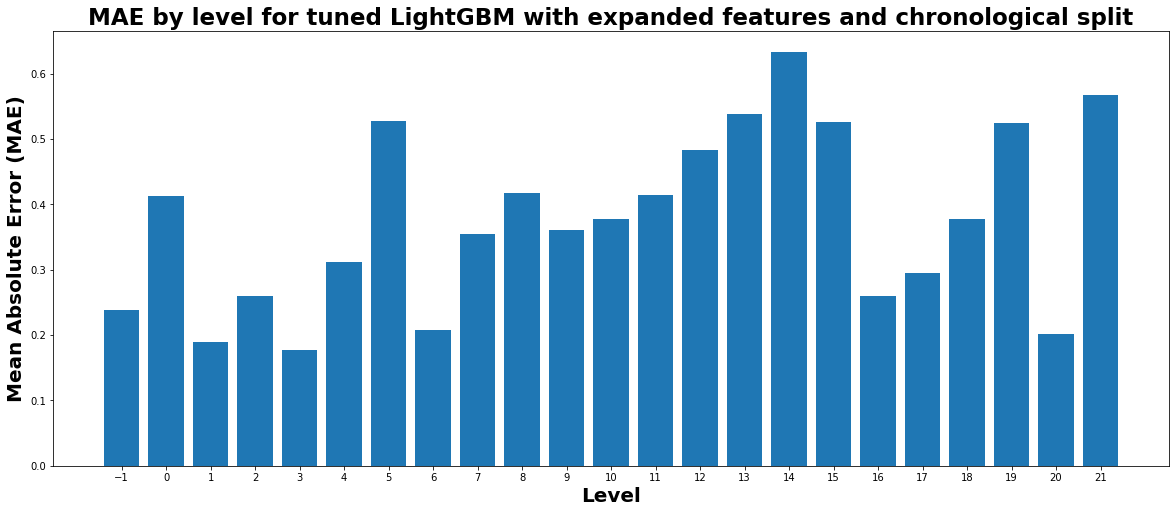

In [27]:
plot_mae_by_level(
    y_test,
    y_pred_test,
    title="MAE by level for tuned LightGBM with expanded features and chronological split",
)

In [28]:
predict = lgb_tuned.predict(X_test)
evaluate_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.46

Round type: 0.5
RMSE: 0.46

Round type: 0.33
RMSE: 0.50

Round type: 0.45
RMSE: 0.47



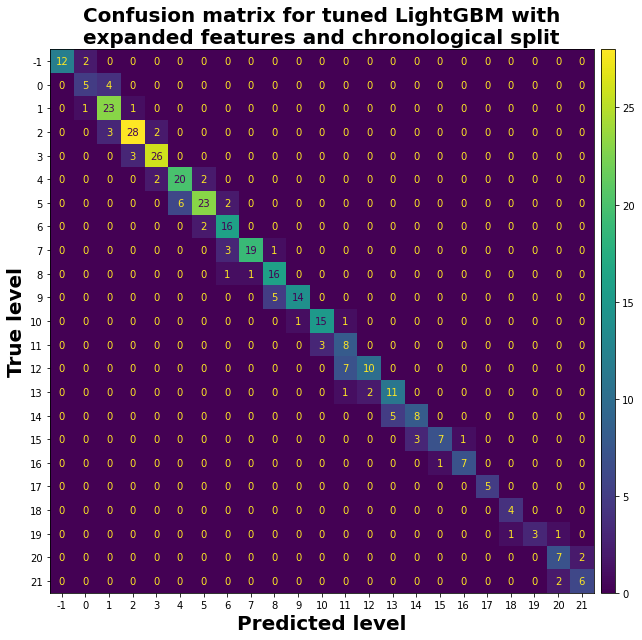

In [29]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with\nexpanded features and chronological split",
)

## Random split

In [30]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)
lgb_eval = lgb.Dataset(X_test_random_split, y_test_random_split, reference=lgb_train)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval,
    callbacks=[lgb.early_stopping(stopping_rounds=5)],
)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 392
[LightGBM] [Info] Number of data points in the train set: 904, number of used features: 13
[LightGBM] [Info] Start training from score 7.162611
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[88]	valid_0's l1: 0.267273	valid_0's l2: 0.148111


In [31]:
y_pred_train = gbm.predict(X_train_random_split, num_iteration=gbm.best_iteration)
y_pred_test = gbm.predict(X_test_random_split, num_iteration=gbm.best_iteration)

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = mean_squared_error(y_test_random_split, y_pred_test, squared=False)
mae = mean_absolute_error(y_test_random_split, y_pred_test)

print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

RMSE: 0.38
MAE: 0.27


In [33]:
results.loc[2] = ["random", "default", "expanded", rmse, mae]

###### MAE by level

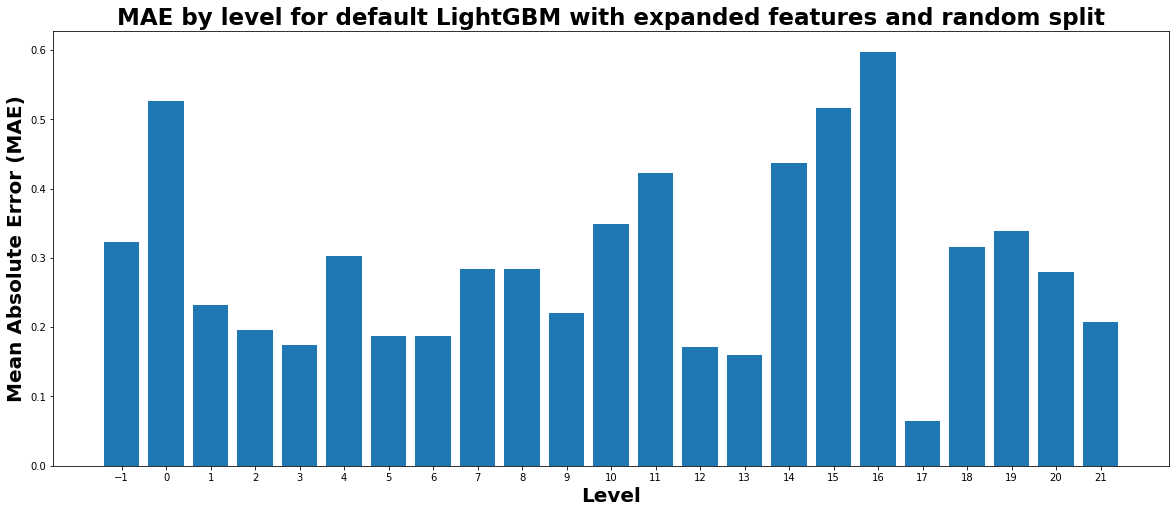

In [34]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for default LightGBM with expanded features and random split",
)

In [35]:
evaluate_round_predictions([0.5, 0.33, 0.45], y_test_random_split, y_pred_test)

Default:
RMSE: 0.38

Round type: 0.5
RMSE: 0.39

Round type: 0.33
RMSE: 0.45

Round type: 0.45
RMSE: 0.41



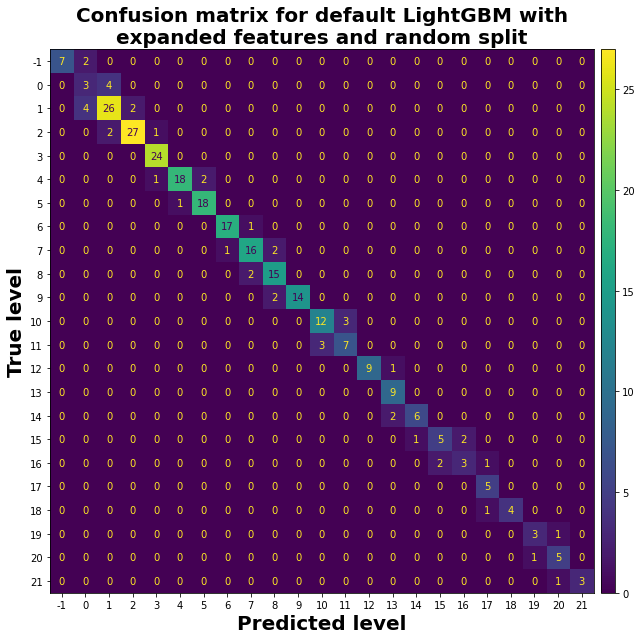

In [36]:
plot_confusion_matrix(
    y_pred_test,
    y_test_random_split,
    title="Confusion matrix for default LightGBM with\nexpanded features and random split",
)

### Tuning

In [37]:
import optuna.integration.lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold


lgb_train = lgb.Dataset(X_train_random_split, y_train_random_split)

params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": "l2",
    "verbosity": -1,
}

tuner = lgb.LightGBMTunerCV(
    params,
    lgb_train,
    folds=KFold(n_splits=5),
    num_boost_round=10000,
    callbacks=[early_stopping(100), log_evaluation(100)],
)

tuner.run()

[I 2023-11-09 20:51:07,834] A new study created in memory with name: no-name-fc6b1c03-194a-416a-9675-49c16f395006
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	cv_agg's l2: 0.187352 + 0.0576399
[200]	cv_agg's l2: 0.187791 + 0.0566425


feature_fraction, val_score: 0.186709:  14%|######4                                      | 1/7 [00:01<00:11,  1.93s/it]

Early stopping, best iteration is:
[131]	cv_agg's l2: 0.186709 + 0.0571791
[100]	cv_agg's l2: 0.184772 + 0.0440265
[200]	cv_agg's l2: 0.18234 + 0.0420791
[300]	cv_agg's l2: 0.182703 + 0.0417769


feature_fraction, val_score: 0.182040:  29%|############8                                | 2/7 [00:05<00:14,  2.81s/it]

Early stopping, best iteration is:
[229]	cv_agg's l2: 0.18204 + 0.0417122
[100]	cv_agg's l2: 0.192038 + 0.0413721
[200]	cv_agg's l2: 0.189522 + 0.0412893
[300]	cv_agg's l2: 0.191231 + 0.0417325


feature_fraction, val_score: 0.182040:  43%|###################2                         | 3/7 [00:09<00:13,  3.36s/it]

Early stopping, best iteration is:
[229]	cv_agg's l2: 0.18204 + 0.0417122
[100]	cv_agg's l2: 0.16129 + 0.035217


feature_fraction, val_score: 0.160720:  57%|#########################7                   | 4/7 [00:11<00:08,  2.97s/it]

[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909
[100]	cv_agg's l2: 0.175735 + 0.0463338


feature_fraction, val_score: 0.160720:  71%|################################1            | 5/7 [00:14<00:05,  2.80s/it]

[200]	cv_agg's l2: 0.174902 + 0.0436904
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909
[100]	cv_agg's l2: 0.184401 + 0.0479093


feature_fraction, val_score: 0.160720:  86%|######################################5      | 6/7 [00:16<00:02,  2.72s/it]

[200]	cv_agg's l2: 0.182678 + 0.0442488
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909
[100]	cv_agg's l2: 0.180332 + 0.0623291


feature_fraction, val_score: 0.160720: 100%|#############################################| 7/7 [00:19<00:00,  2.76s/it]


[200]	cv_agg's l2: 0.177797 + 0.0583312
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909


num_leaves, val_score: 0.160720:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.16129 + 0.035217


num_leaves, val_score: 0.160720:   5%|##5                                               | 1/20 [00:02<00:47,  2.47s/it]

[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909
[100]	cv_agg's l2: 0.16129 + 0.035217


num_leaves, val_score: 0.160720:  10%|#####                                             | 2/20 [00:04<00:43,  2.41s/it]

[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909
[100]	cv_agg's l2: 0.16129 + 0.035217


num_leaves, val_score: 0.160720:  15%|#######5                                          | 3/20 [00:07<00:41,  2.43s/it]

[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909
[100]	cv_agg's l2: 0.234748 + 0.0469587
[200]	cv_agg's l2: 0.207647 + 0.0390915


num_leaves, val_score: 0.160720:  20%|##########                                        | 4/20 [00:07<00:26,  1.66s/it]

Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909
[100]	cv_agg's l2: 0.16129 + 0.035217
[200]	cv_agg's l2: 0.161307 + 0.0322848


num_leaves, val_score: 0.160720:  25%|############5                                     | 5/20 [00:10<00:31,  2.09s/it]

Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909
[100]	cv_agg's l2: 0.16129 + 0.035217


num_leaves, val_score: 0.160720:  25%|############5                                     | 5/20 [00:13<00:31,  2.09s/it]

[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909


num_leaves, val_score: 0.160720:  30%|###############                                   | 6/20 [00:13<00:33,  2.38s/it]

[100]	cv_agg's l2: 0.16129 + 0.035217


num_leaves, val_score: 0.160720:  30%|###############                                   | 6/20 [00:16<00:33,  2.38s/it]

[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909


num_leaves, val_score: 0.160720:  35%|#################5                                | 7/20 [00:16<00:32,  2.49s/it]

[100]	cv_agg's l2: 0.16129 + 0.035217


num_leaves, val_score: 0.160720:  35%|#################5                                | 7/20 [00:18<00:32,  2.49s/it]

[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909


num_leaves, val_score: 0.160720:  40%|####################                              | 8/20 [00:18<00:30,  2.56s/it]

[100]	cv_agg's l2: 0.16129 + 0.035217


num_leaves, val_score: 0.160720:  40%|####################                              | 8/20 [00:21<00:30,  2.56s/it]

[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909


num_leaves, val_score: 0.160720:  45%|######################5                           | 9/20 [00:21<00:28,  2.59s/it]

[100]	cv_agg's l2: 0.16129 + 0.035217


num_leaves, val_score: 0.160720:  50%|########################5                        | 10/20 [00:24<00:26,  2.63s/it][I 2023-11-09 20:51:51,531] Trial 16 finished with value: 0.16072002131845703 and parameters: {'num_leaves': 43}. Best is trial 7 with value: 0.16072002131845703.


[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909


num_leaves, val_score: 0.160720:  50%|########################5                        | 10/20 [00:24<00:26,  2.63s/it]

[100]	cv_agg's l2: 0.16129 + 0.035217


num_leaves, val_score: 0.160720:  55%|##########################9                      | 11/20 [00:27<00:23,  2.63s/it]

[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909
[100]	cv_agg's l2: 0.16129 + 0.035217


num_leaves, val_score: 0.160720:  55%|##########################9                      | 11/20 [00:29<00:23,  2.63s/it]

[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909


num_leaves, val_score: 0.160720:  60%|#############################4                   | 12/20 [00:29<00:21,  2.66s/it]

[100]	cv_agg's l2: 0.16129 + 0.035217


num_leaves, val_score: 0.160720:  60%|#############################4                   | 12/20 [00:32<00:21,  2.66s/it]

[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909


num_leaves, val_score: 0.160720:  65%|###############################8                 | 13/20 [00:32<00:18,  2.70s/it]

[100]	cv_agg's l2: 0.16129 + 0.035217


num_leaves, val_score: 0.160720:  65%|###############################8                 | 13/20 [00:35<00:18,  2.70s/it]

[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909


num_leaves, val_score: 0.160720:  70%|##################################3              | 14/20 [00:35<00:16,  2.70s/it]

[100]	cv_agg's l2: 0.16129 + 0.035217


num_leaves, val_score: 0.160720:  75%|####################################7            | 15/20 [00:37<00:13,  2.66s/it][I 2023-11-09 20:52:04,937] Trial 21 finished with value: 0.16072002131845703 and parameters: {'num_leaves': 77}. Best is trial 7 with value: 0.16072002131845703.


[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909


num_leaves, val_score: 0.160720:  75%|####################################7            | 15/20 [00:37<00:13,  2.66s/it]

[100]	cv_agg's l2: 0.16129 + 0.035217


num_leaves, val_score: 0.160720:  75%|####################################7            | 15/20 [00:40<00:13,  2.66s/it]

[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909


num_leaves, val_score: 0.160720:  80%|#######################################2         | 16/20 [00:40<00:10,  2.66s/it]

[100]	cv_agg's l2: 0.16129 + 0.035217


num_leaves, val_score: 0.160720:  80%|#######################################2         | 16/20 [00:43<00:10,  2.66s/it]

[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909


num_leaves, val_score: 0.160720:  85%|#########################################6       | 17/20 [00:43<00:07,  2.65s/it]

[100]	cv_agg's l2: 0.162397 + 0.0358675


num_leaves, val_score: 0.160720:  90%|############################################1    | 18/20 [00:45<00:05,  2.64s/it]

[200]	cv_agg's l2: 0.163157 + 0.0338166
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909
[100]	cv_agg's l2: 0.16129 + 0.035217


num_leaves, val_score: 0.160720:  95%|##############################################5  | 19/20 [00:48<00:02,  2.61s/it]

[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909
[100]	cv_agg's l2: 0.16129 + 0.035217


num_leaves, val_score: 0.160720: 100%|#################################################| 20/20 [00:50<00:00,  2.54s/it]


[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909


bagging, val_score: 0.160720:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.171611 + 0.0381719


bagging, val_score: 0.160720:  10%|#####3                                               | 1/10 [00:02<00:19,  2.15s/it]

[200]	cv_agg's l2: 0.170991 + 0.0342478
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909
[100]	cv_agg's l2: 0.216542 + 0.0293949


bagging, val_score: 0.160720:  20%|##########6                                          | 2/10 [00:03<00:13,  1.68s/it]

[200]	cv_agg's l2: 0.210531 + 0.0261739
Early stopping, best iteration is:
[114]	cv_agg's l2: 0.16072 + 0.0346909
[100]	cv_agg's l2: 0.160652 + 0.0356734


bagging, val_score: 0.160301:  30%|###############9                                     | 3/10 [00:05<00:13,  1.92s/it]

Early stopping, best iteration is:
[80]	cv_agg's l2: 0.160301 + 0.0363427
[100]	cv_agg's l2: 0.161585 + 0.0375255


bagging, val_score: 0.160301:  40%|#####################2                               | 4/10 [00:07<00:12,  2.03s/it]

Early stopping, best iteration is:
[80]	cv_agg's l2: 0.160301 + 0.0363427
[100]	cv_agg's l2: 0.158519 + 0.0353953


bagging, val_score: 0.158154:  40%|#####################2                               | 4/10 [00:10<00:12,  2.03s/it]

[200]	cv_agg's l2: 0.159718 + 0.0323892
Early stopping, best iteration is:
[117]	cv_agg's l2: 0.158154 + 0.0332823


bagging, val_score: 0.158154:  50%|##########################5                          | 5/10 [00:10<00:11,  2.26s/it]

[100]	cv_agg's l2: 0.158224 + 0.0371886


bagging, val_score: 0.157745:  60%|###############################8                     | 6/10 [00:12<00:09,  2.27s/it]

Early stopping, best iteration is:
[92]	cv_agg's l2: 0.157745 + 0.0364452
[100]	cv_agg's l2: 0.157606 + 0.0351021


bagging, val_score: 0.157200:  70%|#####################################                | 7/10 [00:15<00:07,  2.39s/it]

[200]	cv_agg's l2: 0.158933 + 0.0324842
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.16129 + 0.035217


bagging, val_score: 0.157200:  80%|##########################################4          | 8/10 [00:18<00:04,  2.44s/it]

[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.15969 + 0.0339605


bagging, val_score: 0.157200:  90%|###############################################7     | 9/10 [00:20<00:02,  2.49s/it]

[200]	cv_agg's l2: 0.161348 + 0.0318443
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.16129 + 0.035217


bagging, val_score: 0.157200: 100%|####################################################| 10/10 [00:23<00:00,  2.35s/it]


[200]	cv_agg's l2: 0.161307 + 0.0322848
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321


feature_fraction_stage2, val_score: 0.157200:   0%|                                              | 0/3 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.179267 + 0.0502528


feature_fraction_stage2, val_score: 0.157200:  33%|############6                         | 1/3 [00:02<00:05,  2.96s/it]

[200]	cv_agg's l2: 0.179095 + 0.0467591
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.179267 + 0.0502528


feature_fraction_stage2, val_score: 0.157200:  67%|#########################3            | 2/3 [00:05<00:02,  2.74s/it]

[200]	cv_agg's l2: 0.179095 + 0.0467591
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.157606 + 0.0351021


feature_fraction_stage2, val_score: 0.157200: 100%|######################################| 3/3 [00:08<00:00,  2.73s/it]


[200]	cv_agg's l2: 0.158933 + 0.0324842
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321


regularization_factors, val_score: 0.157200:   0%|                                              | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.159056 + 0.0385192


regularization_factors, val_score: 0.157200:   5%|#9                                    | 1/20 [00:02<00:47,  2.49s/it]

[200]	cv_agg's l2: 0.161131 + 0.0359388
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.159563 + 0.0348859


regularization_factors, val_score: 0.157200:  10%|###8                                  | 2/20 [00:05<00:45,  2.54s/it]

[200]	cv_agg's l2: 0.162512 + 0.0344578
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.157606 + 0.0351021


regularization_factors, val_score: 0.157200:  15%|#####7                                | 3/20 [00:07<00:43,  2.56s/it]

[200]	cv_agg's l2: 0.158933 + 0.0324842
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.16725 + 0.0392414


regularization_factors, val_score: 0.157200:  20%|#######6                              | 4/20 [00:09<00:34,  2.18s/it]

[200]	cv_agg's l2: 0.164257 + 0.03783
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.158019 + 0.0353932


regularization_factors, val_score: 0.157200:  25%|#########5                            | 5/20 [00:11<00:35,  2.38s/it]

[200]	cv_agg's l2: 0.160919 + 0.0326904
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.158019 + 0.0353932


regularization_factors, val_score: 0.157200:  30%|###########4                          | 6/20 [00:14<00:34,  2.46s/it]

[200]	cv_agg's l2: 0.161267 + 0.0328381
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.158666 + 0.0366293


regularization_factors, val_score: 0.157200:  35%|#############3                        | 7/20 [00:17<00:33,  2.54s/it]

[200]	cv_agg's l2: 0.161165 + 0.0333319
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.16597 + 0.0412472


regularization_factors, val_score: 0.157200:  40%|###############2                      | 8/20 [00:19<00:30,  2.52s/it]

[200]	cv_agg's l2: 0.165739 + 0.0386027
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.157954 + 0.0345344


regularization_factors, val_score: 0.157200:  45%|#################1                    | 9/20 [00:22<00:27,  2.54s/it]

[200]	cv_agg's l2: 0.160288 + 0.0314299
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.158911 + 0.0346324


regularization_factors, val_score: 0.157200:  50%|##################5                  | 10/20 [00:24<00:25,  2.56s/it]

[200]	cv_agg's l2: 0.160361 + 0.0315996
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.158911 + 0.0346324


regularization_factors, val_score: 0.157200:  55%|####################3                | 11/20 [00:27<00:23,  2.60s/it]

[200]	cv_agg's l2: 0.160361 + 0.0315995
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.157606 + 0.0351021


regularization_factors, val_score: 0.157200:  60%|######################2              | 12/20 [00:30<00:21,  2.66s/it]

[200]	cv_agg's l2: 0.159583 + 0.0322233
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.157606 + 0.0351021


regularization_factors, val_score: 0.157200:  65%|########################             | 13/20 [00:33<00:18,  2.65s/it]

[200]	cv_agg's l2: 0.159583 + 0.0322233
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.157606 + 0.0351021


regularization_factors, val_score: 0.157200:  70%|#########################9           | 14/20 [00:35<00:15,  2.63s/it]

[200]	cv_agg's l2: 0.159583 + 0.0322233
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.157606 + 0.0351021


regularization_factors, val_score: 0.157200:  75%|###########################7         | 15/20 [00:38<00:13,  2.68s/it]

[200]	cv_agg's l2: 0.159583 + 0.0322233
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.157606 + 0.0351021


regularization_factors, val_score: 0.157200:  80%|#############################6       | 16/20 [00:41<00:10,  2.68s/it]

[200]	cv_agg's l2: 0.159583 + 0.0322233
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.157606 + 0.0351021


regularization_factors, val_score: 0.157200:  85%|###############################4     | 17/20 [00:43<00:08,  2.70s/it]

[200]	cv_agg's l2: 0.159583 + 0.0322233
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.157606 + 0.0351021


regularization_factors, val_score: 0.157200:  90%|#################################3   | 18/20 [00:46<00:05,  2.66s/it]

[200]	cv_agg's l2: 0.159583 + 0.0322233
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.157606 + 0.0351021


regularization_factors, val_score: 0.157200:  95%|###################################1 | 19/20 [00:49<00:02,  2.64s/it]

[200]	cv_agg's l2: 0.159583 + 0.0322233
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.157606 + 0.0351021


regularization_factors, val_score: 0.157200: 100%|#####################################| 20/20 [00:51<00:00,  2.60s/it]


[200]	cv_agg's l2: 0.159583 + 0.0322233
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321


min_data_in_leaf, val_score: 0.157200:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's l2: 0.233254 + 0.0397841


min_data_in_leaf, val_score: 0.157200:  20%|#########                                    | 1/5 [00:01<00:06,  1.52s/it]

[200]	cv_agg's l2: 0.223199 + 0.0342109
Early stopping, best iteration is:
[105]	cv_agg's l2: 0.1572 + 0.0347321
[100]	cv_agg's l2: 0.151921 + 0.035315
[200]	cv_agg's l2: 0.151789 + 0.0344516


min_data_in_leaf, val_score: 0.150950:  40%|##################                           | 2/5 [00:07<00:13,  4.41s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.15095 + 0.0348538
[100]	cv_agg's l2: 0.168799 + 0.0377662
[200]	cv_agg's l2: 0.169056 + 0.0354895


min_data_in_leaf, val_score: 0.150950:  60%|###########################                  | 3/5 [00:11<00:07,  3.98s/it]

Early stopping, best iteration is:
[146]	cv_agg's l2: 0.15095 + 0.0348538
[100]	cv_agg's l2: 0.675068 + 0.0554865


min_data_in_leaf, val_score: 0.150950:  60%|###########################                  | 3/5 [00:12<00:07,  3.98s/it]

[200]	cv_agg's l2: 0.635306 + 0.0511241
Early stopping, best iteration is:
[146]	cv_agg's l2: 0.15095 + 0.0348538


min_data_in_leaf, val_score: 0.150950:  80%|####################################         | 4/5 [00:12<00:02,  2.80s/it]

[100]	cv_agg's l2: 0.147859 + 0.0328375
[200]	cv_agg's l2: 0.148288 + 0.0322643


min_data_in_leaf, val_score: 0.147168: 100%|#############################################| 5/5 [00:17<00:00,  3.59s/it]

Early stopping, best iteration is:
[167]	cv_agg's l2: 0.147168 + 0.0316004


In [38]:
print(f"Best score: {tuner.best_score}")
best_params = tuner.best_params
print("Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

Best score: 0.14716756464291186
Params: 
    boosting_type: gbdt
    objective: regression
    metric: l2
    verbosity: -1
    feature_pre_filter: False
    lambda_l1: 6.088896667143144e-07
    lambda_l2: 8.913533166578145e-06
    num_leaves: 31
    feature_fraction: 0.4
    bagging_fraction: 0.9826348845290551
    bagging_freq: 1
    min_child_samples: 10


In [39]:
import lightgbm as lgb

lgb_tuned = lgb.train(
    best_params,
    lgb_train,
    num_boost_round=10000,
)

In [40]:
rmse, mae = assess_regression_model(
    lgb_tuned,
    X_train_random_split,
    X_test_random_split,
    y_train_random_split,
    y_test_random_split,
)

RMSE train: 0.00
RMSE test: 0.34
MAE test: 0.23



In [41]:
results.loc[3] = ["random", "Optuna", "expanded", rmse, mae]

###### MAE by level

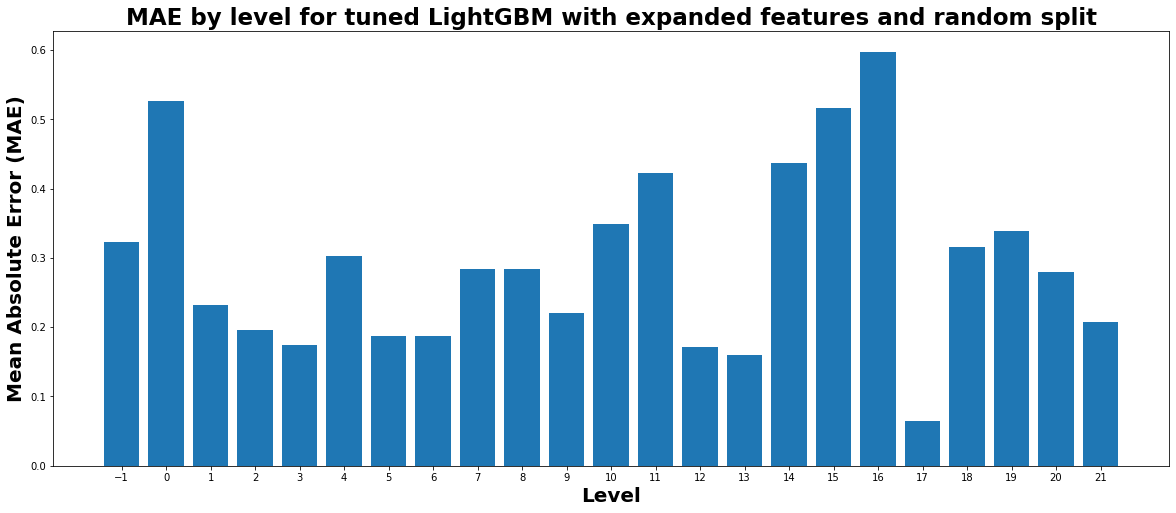

In [42]:
plot_mae_by_level(
    y_test_random_split,
    y_pred_test,
    title="MAE by level for tuned LightGBM with expanded features and random split",
)

In [43]:
predict = lgb_tuned.predict(X_test)
evaluate_round_predictions([0.5, 0.33, 0.45], y_test, predict)

Default:
RMSE: 0.21

Round type: 0.5
RMSE: 0.23

Round type: 0.33
RMSE: 0.25

Round type: 0.45
RMSE: 0.23



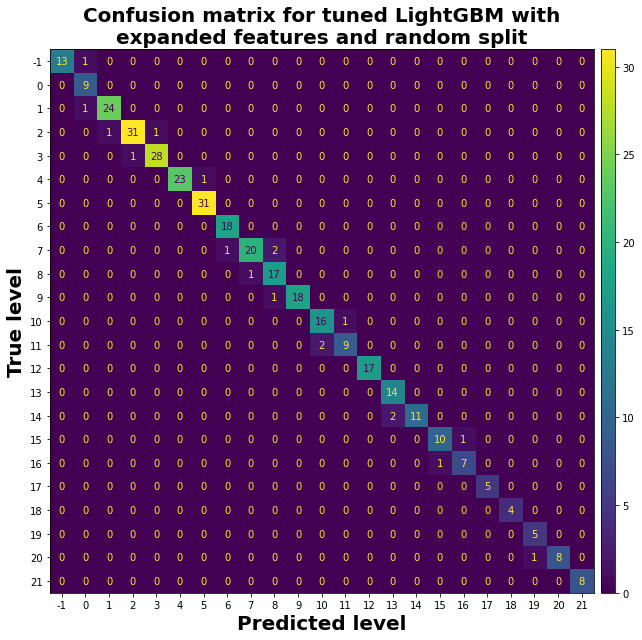

In [44]:
plot_confusion_matrix(
    predict,
    y_test,
    title="Confusion matrix for tuned LightGBM with\nexpanded features and random split",
)

## Summary

In [45]:
results

,Split type,Tuning type,Set of features,RMSE,MAE
0,chronological,default,expanded,0.510755,0.357180
1,chronological,Optuna,expanded,0.456978,0.334893
2,random,default,expanded,0.384853,0.267273
3,random,Optuna,expanded,0.343850,0.230400


In [46]:
from training.results import plot_summary

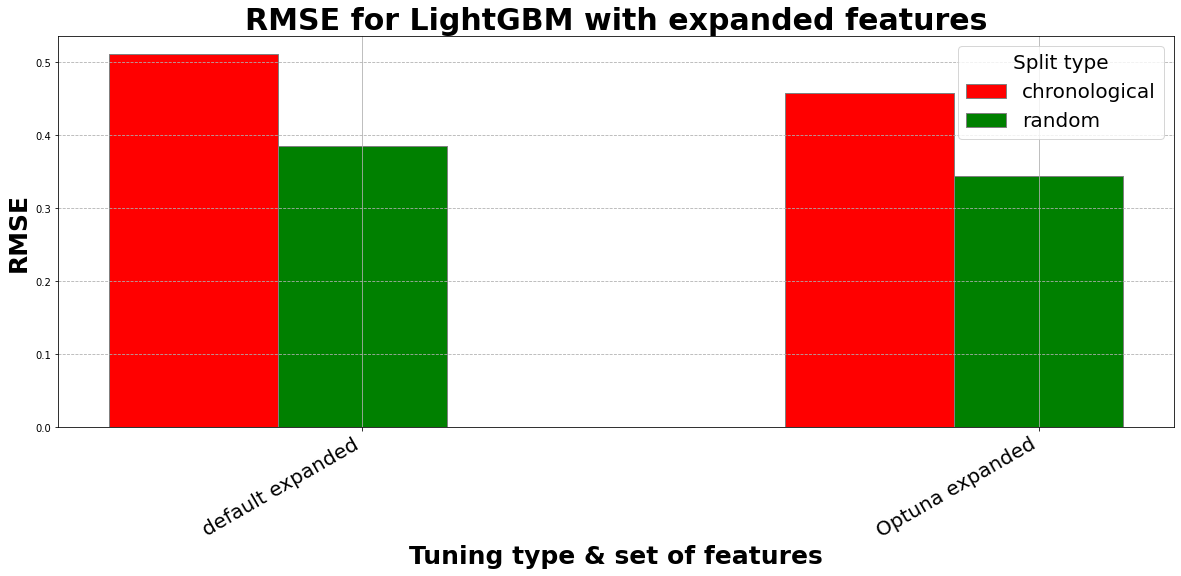

In [47]:
plot_summary(results, "RMSE", title="RMSE for LightGBM with expanded features")

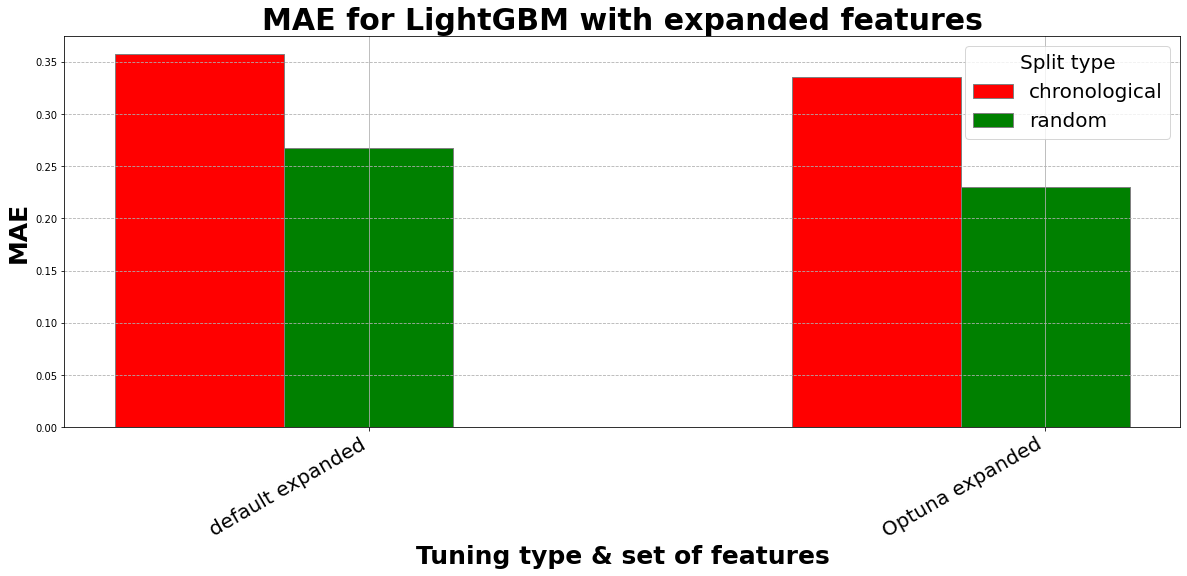

In [48]:
plot_summary(results, "MAE", title="MAE for LightGBM with expanded features")

In [49]:
results.to_csv("./lightgbm_expanded_results.csv")